In [1]:
%load_ext autoreload
%autoreload 2

In [92]:
import spikeinterface.full as si
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.io import savemat
import shutil
import dartsort
import dartsort.vis as dartvis
import torch
import analysis_tools
from dredge import motion_util
from scipy.spatial import KDTree
import pickle

In [3]:
rec_dir = Path("/home/cwindolf/proj/measimdense/")
out_dir = Path("/home/cwindolf/proj/sparsity_experiment")
out_dir.mkdir(exist_ok=True)

In [43]:
dart_out_dir = out_dir / "dredge"
dart_out_dir.mkdir(exist_ok=True)

In [4]:
!ls {rec_dir}/recordings

NPx-Like-Dense_rigid_uniform_homogeneous.h5


In [5]:
rec, sorting = si.read_mearec(next((rec_dir / "recordings").glob("*.h5")))

In [6]:
geom = rec.get_channel_locations()
geom[:8]

array([[ -24., -504.],
       [ -24., -488.],
       [ -24., -472.],
       [ -24., -456.],
       [ -24., -440.],
       [ -24., -424.],
       [ -24., -408.],
       [ -24., -392.]])

In [7]:
uniq_y, row_ix = np.unique(geom[:, 1], return_inverse=True)
uniq_x, col_ix = np.unique(geom[:, 0], return_inverse=True)
uniq_y.size, uniq_x.size

(64, 4)

In [63]:
row_ix.size, col_ix.size

(256, 256)

In [84]:
layouts = {
    "Full": np.ones(rec.get_num_channels(), dtype=bool),
    "NP2-Like": col_ix % 2 == 0,
    "NP1-Like": (row_ix + col_ix) % 2 == 0,
    "NP2-Column": col_ix == 0,
    "NP1-Column": (col_ix == 0) & ((row_ix + col_ix) % 2 == 0),
    "Sparse-Stagger": (row_ix % 2 == 0) & ((row_ix + col_ix) % 4 == 0),
    "Sparse-Column": (col_ix == 0) & (row_ix % 4 == 0),
}

In [85]:
show_mask = (28 <= row_ix) & (row_ix < 36)

Text(0.5, 0.98, "Visualizing layouts as subsets of the central 8 of the full layout's 64 rows")

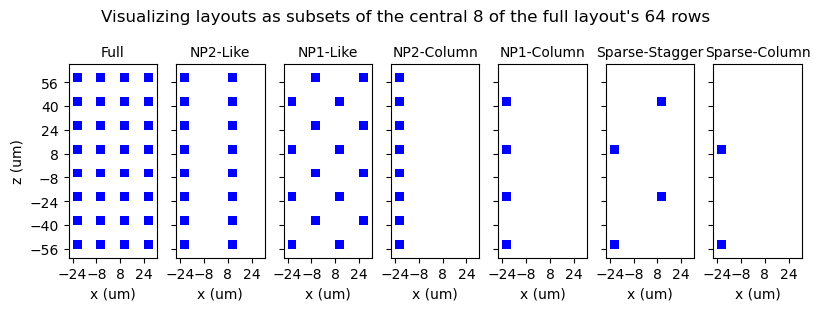

In [89]:
fig, axes = plt.subplots(figsize=(8, 3), ncols=len(layouts), sharey=True, sharex=True, layout='constrained')

colors = ["k", (1, 0, 0), (0, 0, 1), (1, 0.5, 0.5), (0.5, 0.5, 1)]
geom = rec.get_channel_locations()
for (name, mask), ax in zip(layouts.items(), axes):
    analysis_tools.squares(ax, *geom[show_mask & mask].T, s=6, color="b", linewidth=0)
    ax.set_aspect(1)
    ax.set_title(name, fontsize=10)
    ax.set_xticks(np.unique(geom[show_mask, 0]))
    ax.set_xlabel("x (um)");
axes[0].set_yticks(np.unique(geom[show_mask, 1]));
axes[0].set_ylabel("z (um)")
fig.suptitle("Visualizing subsampled layouts as subsets of the central 8 of the full layout's 64 rows")

In [88]:
for name, mask in layouts.items():
    print(name)
    out_dir = dart_out_dir / name
    out_dir.mkdir(exist_ok=True)

    # subset the recording
    rec1 = rec.channel_slice(rec.channel_ids[mask])
    print(rec1)

    # preprocess
    rec1 = si.highpass_filter(rec1)
    rec1 = si.common_reference(rec1)
    rec1 = si.zscore(rec1, num_chunks_per_segment=100, mode="mean+std")
    print(rec1)

    geom = rec1.get_channel_locations()
    channel_index = torch.tensor(dartsort.make_channel_index(geom, 100.0))
    pipeline = dartsort.WaveformPipeline(
        (
            dartsort.transform.TemporalPCADenoiser(channel_index),
            dartsort.transform.Localization(channel_index, torch.tensor(geom)),
            dartsort.transform.MaxAmplitude(),
        )
    )
    peeler = dartsort.peel.ThresholdAndFeaturize(
        rec1,
        detection_threshold=4,
        chunk_length_samples=int(rec1.sampling_frequency),
        channel_index=channel_index,
        featurization_pipeline=pipeline,
        n_chunks_fit=100,
        spatial_dedup_channel_index=torch.tensor(dartsort.make_channel_index(geom, 75.0))
    )
    peeler.load_or_fit_and_save_models(
        out_dir / "thresholding_models", n_jobs=8,
    )
    thresholding_h5 = peeler.peel(
        out_dir / "thresholding.h5",
        n_jobs=8,
    )
    st = dartsort.DARTsortSorting.from_peeling_hdf5(thresholding_h5)
    me = dartsort.estimate_motion(rec1, st, out_dir, amplitudes_dataset_name="ptp_amplitudes")
    dartvis.visualize_sorting(
        rec1,
        st,
        out_dir / "vis",
        motion_est=me,
        make_sorting_summaries=False,
        make_animations=False,
        make_unit_summaries=False,
        amplitudes_dataset_name='ptp_amplitudes',
    )

Full
ChannelSliceRecording: 256 channels - 32.0kHz - 1 segments - 19,200,000 samples 
                       600.00s (10.00 minutes) - float32 dtype - 18.31 GiB
ZScoreRecording: 256 channels - 32.0kHz - 1 segments - 19,200,000 samples 
                 600.00s (10.00 minutes) - float32 dtype - 18.31 GiB
NP2-Like
ChannelSliceRecording: 128 channels - 32.0kHz - 1 segments - 19,200,000 samples 
                       600.00s (10.00 minutes) - float32 dtype - 9.16 GiB
ZScoreRecording: 128 channels - 32.0kHz - 1 segments - 19,200,000 samples 
                 600.00s (10.00 minutes) - float32 dtype - 9.16 GiB
NP1-Like
ChannelSliceRecording: 128 channels - 32.0kHz - 1 segments - 19,200,000 samples 
                       600.00s (10.00 minutes) - float32 dtype - 9.16 GiB
ZScoreRecording: 128 channels - 32.0kHz - 1 segments - 19,200,000 samples 
                 600.00s (10.00 minutes) - float32 dtype - 9.16 GiB
NP2-Column
ChannelSliceRecording: 64 channels - 32.0kHz - 1 segments - 19,200,000

Fit features 1.0s/it [spk/it=%%%]:   0%|          | 0/100 [00:00<?, ?it/s]

Got 65878 spikes, enough to stop early.


Threshold 4 1.0s/it [spk/it=%%%]:   0%|          | 0/600 [00:00<?, ?it/s]

Cross correlation:   0%|          | 0/2 [00:00<?, ?it/s]

Solve:   0%|          | 0/1 [00:00<?, ?it/s]

Sparse-Column
ChannelSliceRecording: 16 channels - 32.0kHz - 1 segments - 19,200,000 samples 
                       600.00s (10.00 minutes) - float32 dtype - 1.14 GiB
ZScoreRecording: 16 channels - 32.0kHz - 1 segments - 19,200,000 samples - 600.00s (10.00 minutes) 
                 float32 dtype - 1.14 GiB


Fit features 1.0s/it [spk/it=%%%]:   0%|          | 0/100 [00:00<?, ?it/s]

Threshold 4 1.0s/it [spk/it=%%%]:   0%|          | 0/600 [00:00<?, ?it/s]

Cross correlation:   0%|          | 0/2 [00:00<?, ?it/s]

Solve:   0%|          | 0/1 [00:00<?, ?it/s]

In [49]:
gtme, gt_dispmap = analysis_tools.dispmap_from_mearec(next((rec_dir / "recordings").glob("*.h5")))

In [93]:
with open(dart_out_dir / "ground_truth_motion_est.pkl", "wb") as jar:
    pickle.dump(gtme, jar)
with open(dart_out_dir / "ground_truth_dispmap.pkl", "wb") as jar:
    pickle.dump(gt_dispmap, jar)

In [94]:
data = dict(layouts=layouts, geom=rec.get_channel_locations())

In [95]:
with open(dart_out_dir / "geomdata.pkl", "wb") as jar:
    pickle.dump(data, jar)

Full
0.43728695458374167


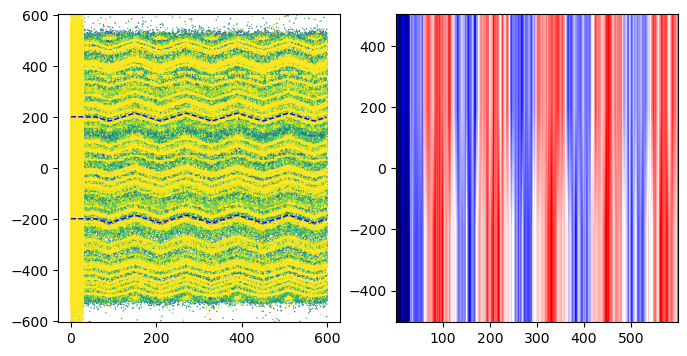

NP2-Like
0.35622085367635503


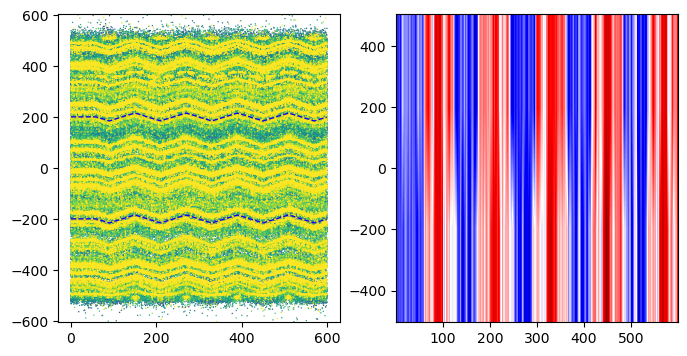

NP1-Like
0.4458768527801043


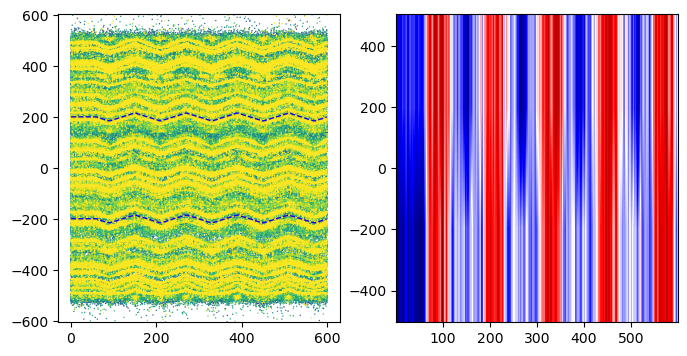

NP2-Column
0.42463293989310086


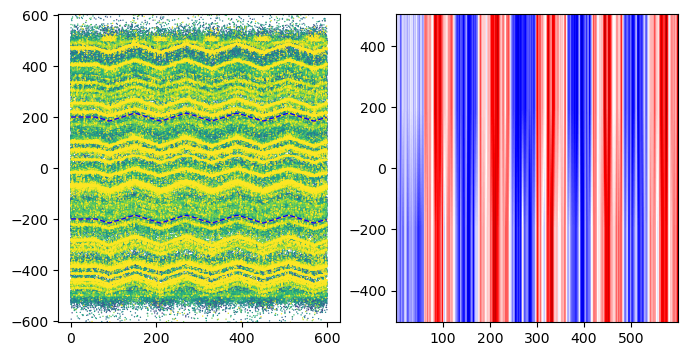

NP1-Column
0.45691759327956016


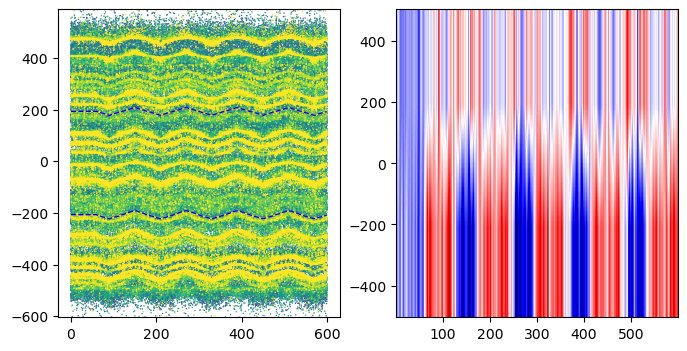

Sparse-Stagger
0.6283854980948329


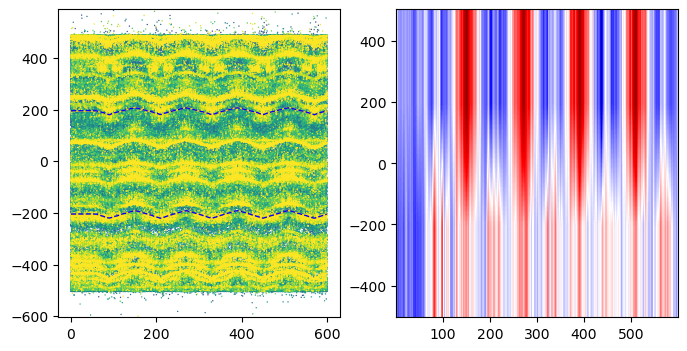

Sparse-Column
4.47573238059876


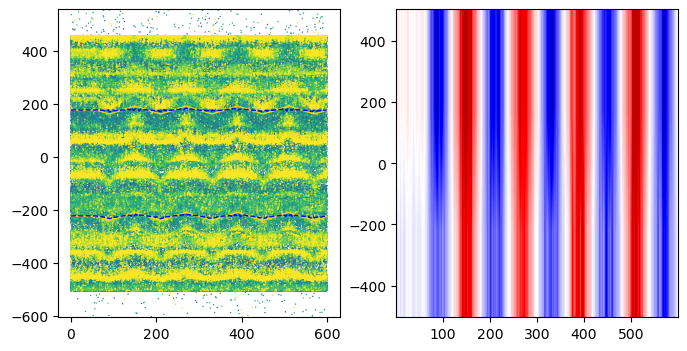

In [90]:
for name, mask in layouts.items():
    out_dir = dart_out_dir / name
    motion_est_pkl = out_dir / "motion_est.pkl"
    me, dm = analysis_tools.dispmap_from_dredge(gt_dispmap, motion_est_pkl)
    spikes = analysis_tools.spikes_from_dredge(out_dir / "thresholding.h5")

    print(name)
    fig, axes = plt.subplots(ncols=2, figsize=(8, 4))
    dartvis.scatter_time_vs_depth(out_dir / "thresholding.h5", ax=axes[0], amplitudes_dataset_name="ptp_amplitudes")
    motion_util.plot_me_traces(gtme, depths_um=me.spatial_bin_centers_um, ax=axes[0], color="gold", lw=1)
    motion_util.plot_me_traces(me, axes[0], color="b", lw=1, ls="--")

    offset = np.mean(gt_dispmap.displacement - dm.displacement)
    error = motion_util.get_motion_estimate(gt_dispmap.displacement - dm.displacement - offset, time_bin_centers_s=dm.time_bin_centers_s, spatial_bin_centers_um=dm.spatial_bin_centers_um)
    vm = np.abs(error.displacement).max()
    motion_util.show_displacement_heatmap(error, ax=axes[1], aspect="auto", vmin=-vm, vmax=vm, cmap=plt.cm.seismic)
    print(np.abs(error.displacement).mean())

    plt.show()
    plt.close(fig)